In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score)

# from utils.helper import fn_plot_confusion_matrix

In [2]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [3]:
# Some basic parameters
inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
BATCH_SIZE = 32 # batch size for training   
TRAIN_SIZE = BATCH_SIZE * 9

EPOCHS = 100 # number of cycles to run
ALPHA = 0.001 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
data_df = pd.read_csv('ionosphere.data', header=None)

In [5]:
X = data_df.drop(data_df.columns[-1], axis = 1).to_numpy()
y = data_df[data_df.columns[-1]].to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= TRAIN_SIZE, 
                                                    stratify=y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288, 34), (63, 34), (288,), (63,))

In [7]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

In [8]:
class_name = list(le.classes_)
class_name

['b', 'g']

In [9]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [10]:
## Some Model Specification

initalizer = tf.keras.initializers.GlorotUniform(seed= RANDOM_STATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape = (34,)),

    tf.keras.layers.Dense(26, activation=tf.keras.activations.relu, kernel_initializer= initalizer),
    tf.keras.layers.Dense(18, activation=tf.keras.activations.relu, kernel_initializer= initalizer),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.relu, kernel_initializer= initalizer),

    tf.keras.layers.Dense(2)
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 26)             │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │           486 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,608 (6.28 KB)

 Trainable params: 1,608 (6.28 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 1 :  Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Step 2 : Optimizer
#ALPHA=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Step 3 :
model1.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# Step 4 :
history = model1.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test))

# Defaulted BATCH_SIZE, verbose =0

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3955 - loss: 0.7667 - val_accuracy: 0.4603 - val_loss: 0.6538
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5033 - loss: 0.6580 - val_accuracy: 0.7937 - val_loss: 0.6024
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7655 - loss: 0.6082 - val_accuracy: 0.8413 - val_loss: 0.5709
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8933 - loss: 0.5599 - val_accuracy: 0.8730 - val_loss: 0.5378
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8895 - loss: 0.5309 - val_accuracy: 0.8730 - val_loss: 0.5010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8945 - loss: 0.4883 - val_accuracy: 0.8889 - val_loss: 0.4630
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8739 - loss: 0.4544 - val_accuracy: 0.8730 - val_loss: 0.4264
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9301 - loss: 0.4036 - val_accuracy: 0.8730 - val_loss: 0.3943

In [12]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.395833,0.742731,0.460317,0.653814
1,0.545139,0.650527,0.793651,0.602414
2,0.788194,0.601686,0.841270,0.570935
3,0.861111,0.563339,0.873016,0.537756
4,0.888889,0.523636,0.873016,0.500970


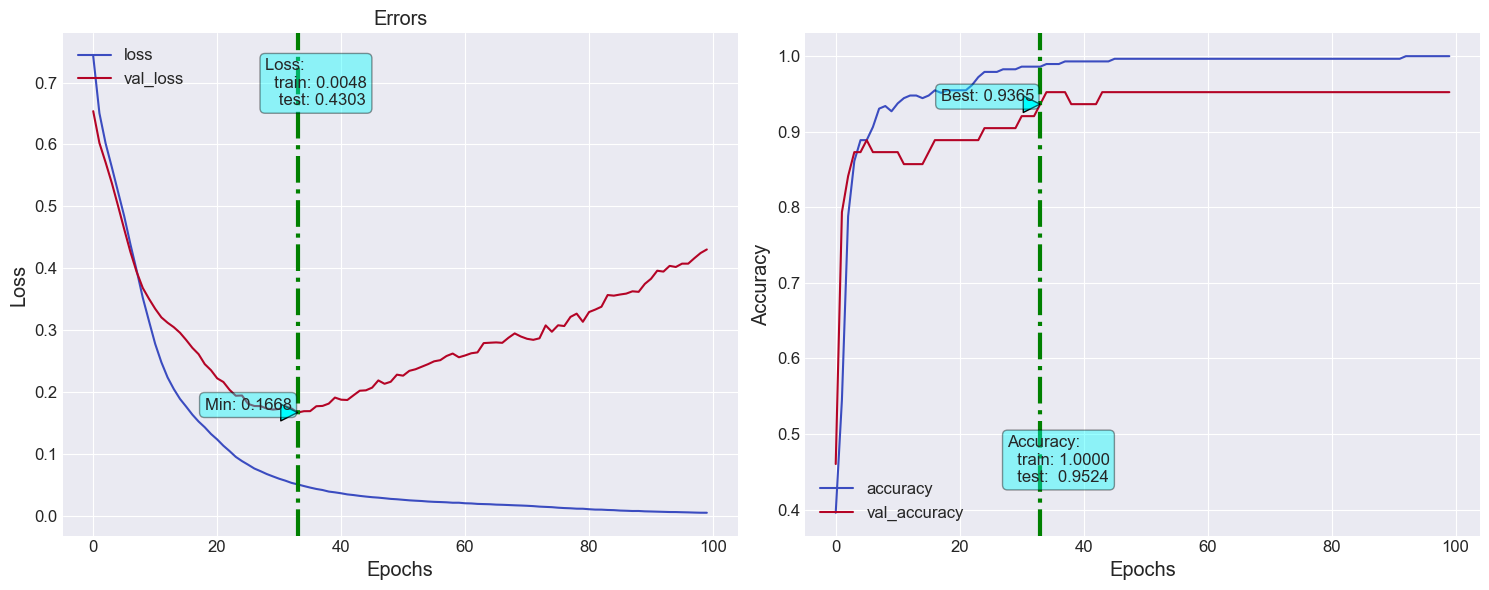

In [13]:
fn_plot_tf_hist(loss_df)